# Traffic Sign Data Visualisation

This notebook loads Label Studio JSON exports, extracts traffic sign attributes and GPS coordinates (from image Exif data), performs analytics, and visualizes the sign locations on a map of Malta.

Daniel Simon Galea, Liam Azzopardi, Liam Jake Vella, Matthew Privitera

In [3]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
from PIL import Image
from PIL.ExifTags import TAGS, GPSTAGS
from pathlib import Path

# Set plot style
sns.set_theme(style="whitegrid")

In [4]:
# Configuration Paths
BASE_DIR = Path(".").resolve()
INDIVIDUAL_JSONS_DIR = BASE_DIR / "data/annotations/Individuals"
MERGED_JSON_PATH = BASE_DIR / "data/annotations/merged_input.json"
IMAGES_DIR = BASE_DIR / "data/images"

print(f"Base Dir: {BASE_DIR}")
print(f"Images Dir: {IMAGES_DIR}")

Base Dir: C:\Users\liamj\Desktop\Advanced-CV-ARI3129
Images Dir: C:\Users\liamj\Desktop\Advanced-CV-ARI3129\data\images


In [5]:
def get_decimal_from_dms(dms, ref):
    degrees = dms[0]
    minutes = dms[1]
    seconds = dms[2]
    
    decimal = degrees + (minutes / 60.0) + (seconds / 3600.0)
    
    if ref in ['S', 'W']:
        decimal = -decimal
        
    return decimal

def get_coordinates_from_image(image_path):
    try:
        image = Image.open(image_path)
        exif_data = image._getexif()
        
        if not exif_data:
            return None, None
            
        gps_info = {}
        for tag, value in exif_data.items():
            tag_name = TAGS.get(tag, tag)
            if tag_name == 'GPSInfo':
                for t in value:
                    sub_tag = GPSTAGS.get(t, t)
                    gps_info[sub_tag] = value[t]
        
        if 'GPSLatitude' in gps_info and 'GPSLongitude' in gps_info:
            lat = get_decimal_from_dms(gps_info['GPSLatitude'], gps_info['GPSLatitudeRef'])
            lon = get_decimal_from_dms(gps_info['GPSLongitude'], gps_info['GPSLongitudeRef'])
            return lat, lon
            
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None, None

In [6]:
def process_json_file(json_path, source_name):
    if not os.path.exists(json_path):
        print(f"File {json_path} not found.")
        return []
        
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    extracted_data = []
    
    for task in data:
        # Identify image filename
        image_filename = task.get('file_upload')
        if not image_filename and 'data' in task:
            image_path_str = task['data'].get('image', '')
            image_filename = os.path.basename(image_path_str)
            
        if not image_filename:
            continue
            
        # Resolve absolute image path
        full_image_path = IMAGES_DIR / image_filename
        
        # Extract GPS
        lat, lon = None, None
        if full_image_path.exists():
            lat, lon = get_coordinates_from_image(full_image_path)

        # Extract Attributes from Annotations
        annotations = task.get('annotations', [])
        
        sign_type = "Unknown"
        view_angle = "Unknown"
        mounting = "Unknown"
        condition = "Unknown"
        sign_shape = "Unknown"
        
        for ann in annotations:
            results = ann.get('result', [])
            for res in results:
                from_name = res.get('from_name')
                value = res.get('value', {})
                
                if from_name == 'sign_type':
                    labels = value.get('rectanglelabels', [])
                    if labels:
                        sign_type = labels[0]
                elif from_name == 'view_angle':
                    choices = value.get('choices', [])
                    if choices:
                        view_angle = choices[0]
                elif from_name == 'mounting':
                    choices = value.get('choices', [])
                    if choices:
                        mounting = choices[0]
                elif from_name == 'condition':
                    choices = value.get('choices', [])
                    if choices:
                        condition = choices[0]
                elif from_name == 'sign_shape':
                    choices = value.get('choices', [])
                    if choices:
                        sign_shape = choices[0]
        
        extracted_data.append({
            'source_file': source_name,
            'image_filename': image_filename,
            'sign_type': sign_type,
            'view_angle': view_angle,
            'mounting': mounting,
            'condition': condition,
            'sign_shape': sign_shape,
            'latitude': lat,
            'longitude': lon
        })
    
    return extracted_data

# Load Individual Files
df_daniel = pd.DataFrame(process_json_file(INDIVIDUAL_JSONS_DIR / "input_Daniel_Simon_Galea.json", "Daniel.json"))
df_liam_azz = pd.DataFrame(process_json_file(INDIVIDUAL_JSONS_DIR / "input_Liam_Azzopardi.json", "LiamAzz.json"))
df_liam_jake = pd.DataFrame(process_json_file(INDIVIDUAL_JSONS_DIR / "input_Liam_Jake_Vella.json", "LiamJake.json"))
df_matthew = pd.DataFrame(process_json_file(INDIVIDUAL_JSONS_DIR / "input_Matthew_Privitera.json", "Matthew.json"))


# Convert to DataFrame (using merged_data if available)
df = pd.DataFrame(process_json_file(MERGED_JSON_PATH, "merged_input.json"))
print(f"Loaded {len(df)} records for merged analysis.")
df.head()

Loaded 703 records for merged analysis.


,source_file,image_filename,sign_type,view_angle,mounting,condition,sign_shape,latitude,longitude
0,merged_input.json,54ef8e6e-back.jpg,Stop,Back,Pole-mounted,Good,Octagonal,35.903703,14.429728
1,merged_input.json,0e9419e0-front.jpg,Stop,Front,Pole-mounted,Good,Octagonal,35.903747,14.429778
2,merged_input.json,7317364e-side.jpg,Stop,Side,Pole-mounted,Good,Octagonal,35.903722,14.429744
3,merged_input.json,d0bd929f-back.jpg,Stop,Back,Pole-mounted,Good,Octagonal,35.903317,14.429650
4,merged_input.json,8e2b5aee-front.jpg,Stop,Front,Pole-mounted,Good,Octagonal,35.903378,14.429697


In [7]:
def plot_distribution(dataframe, title_suffix=""):
    if dataframe.empty:
        print(f"DataFrame for {title_suffix} is empty.")
        return
        
    layout = [
        ['type', 'angle'],
        ['mount', 'cond'],
        ['shape', 'shape'] 
    ]
    
    fig, axes = plt.subplot_mosaic(layout, figsize=(15, 18))
    fig.suptitle(f'Traffic Sign Distribution - {title_suffix}', fontsize=20)

    # Sign Type
    sns.countplot(y='sign_type', data=dataframe, ax=axes['type'], order=dataframe['sign_type'].value_counts().index)
    axes['type'].set_title('Distribution by Sign Type')

    # View Angle
    sns.countplot(x='view_angle', data=dataframe, ax=axes['angle'])
    axes['angle'].set_title('Distribution by View Angle')

    # Mounting
    sns.countplot(x='mounting', data=dataframe, ax=axes['mount'])
    axes['mount'].set_title('Distribution by Mounting')

    # Condition
    sns.countplot(x='condition', data=dataframe, ax=axes['cond'])
    axes['cond'].set_title('Distribution by Condition')

    # Sign Shape (this one will now be centered and wide)
    sns.countplot(x='sign_shape', data=dataframe, ax=axes['shape'])
    axes['shape'].set_title('Distribution by Sign Shape')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## Merged Data Analysis

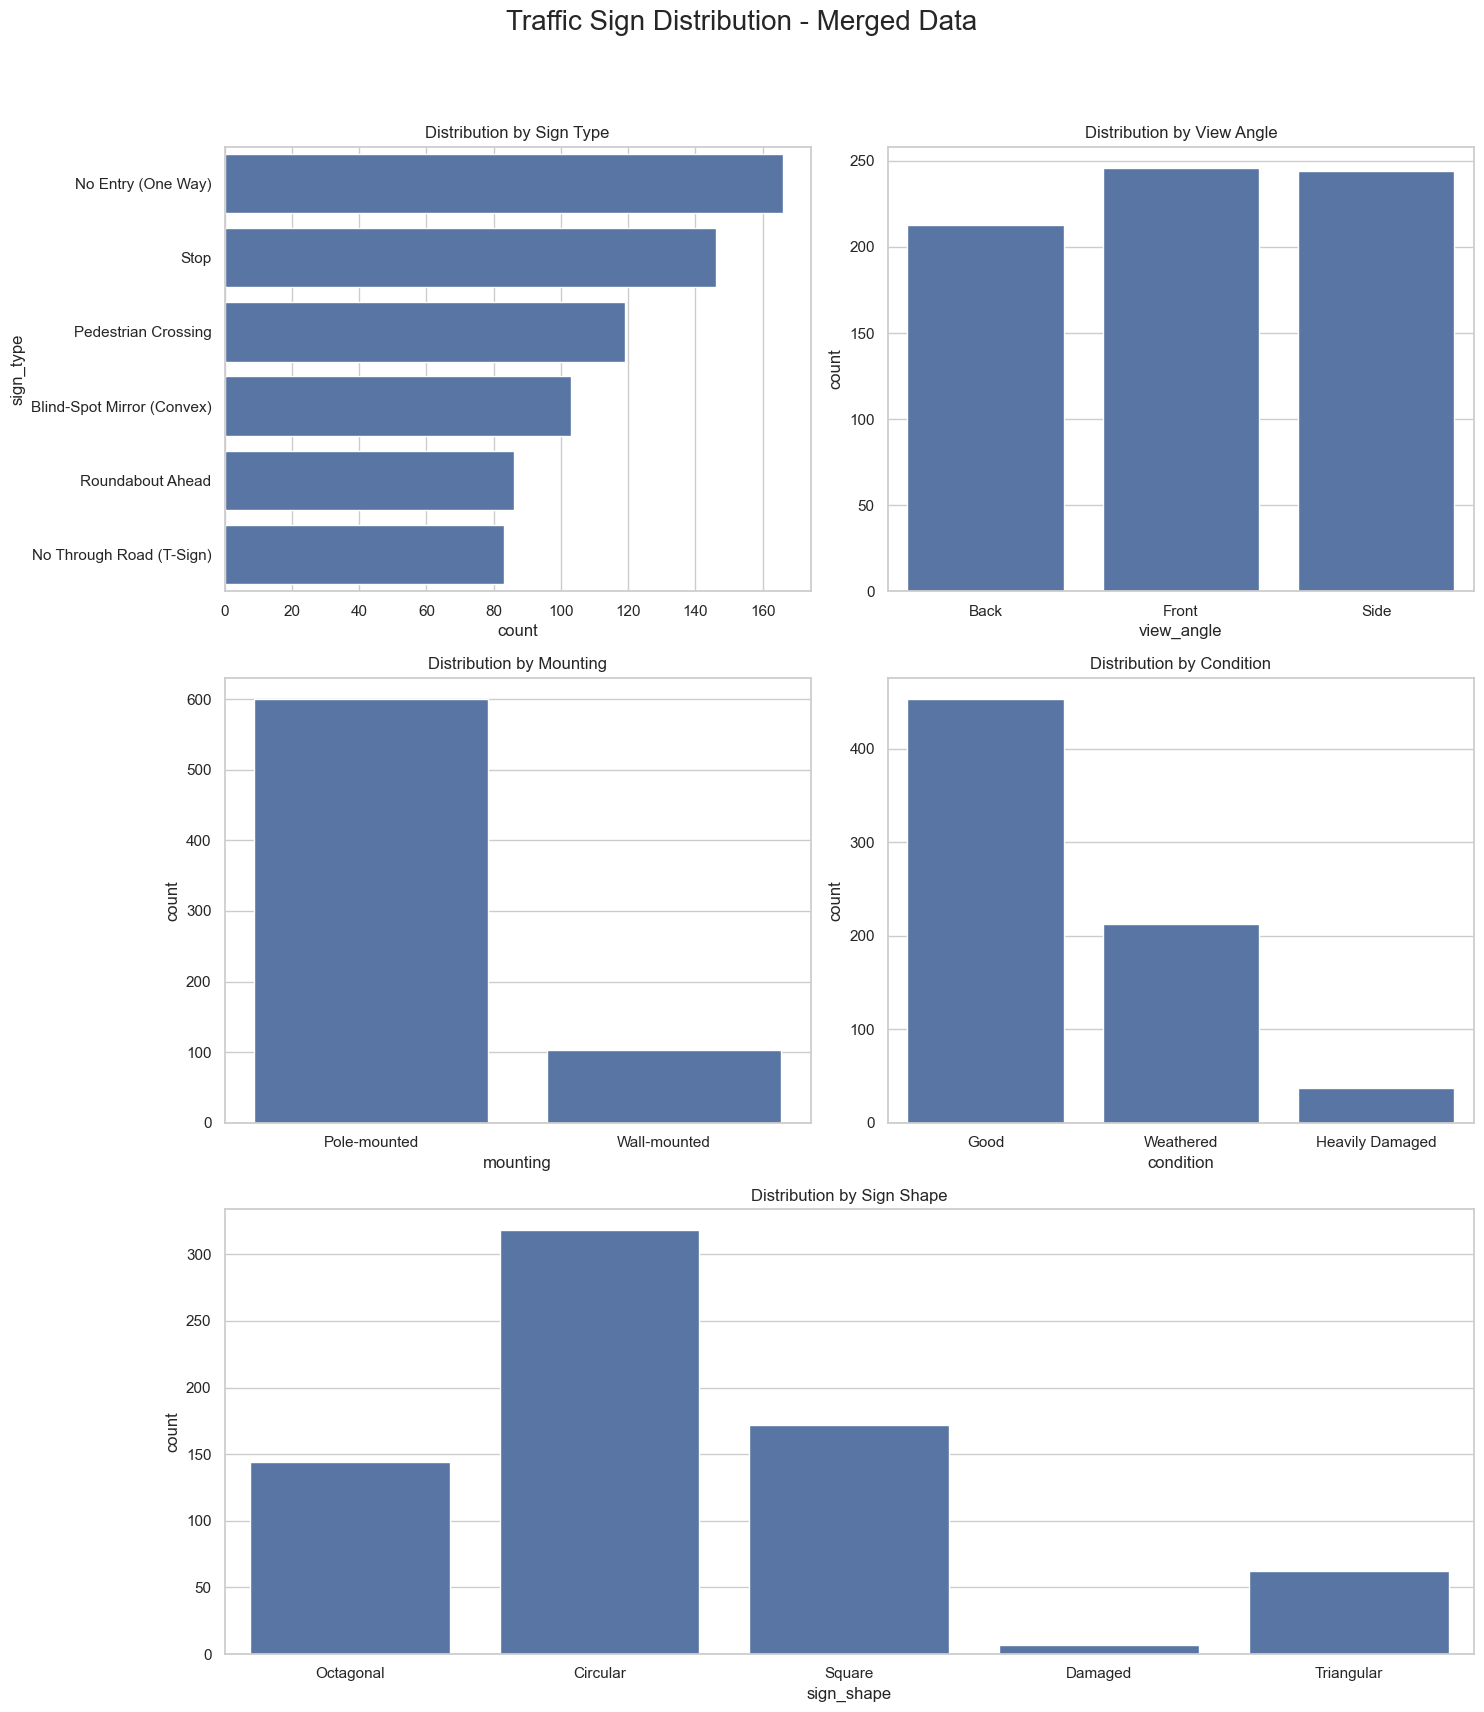

In [8]:
plot_distribution(df, "Merged Data")

## Individual Analysis - Daniel Simon Galea

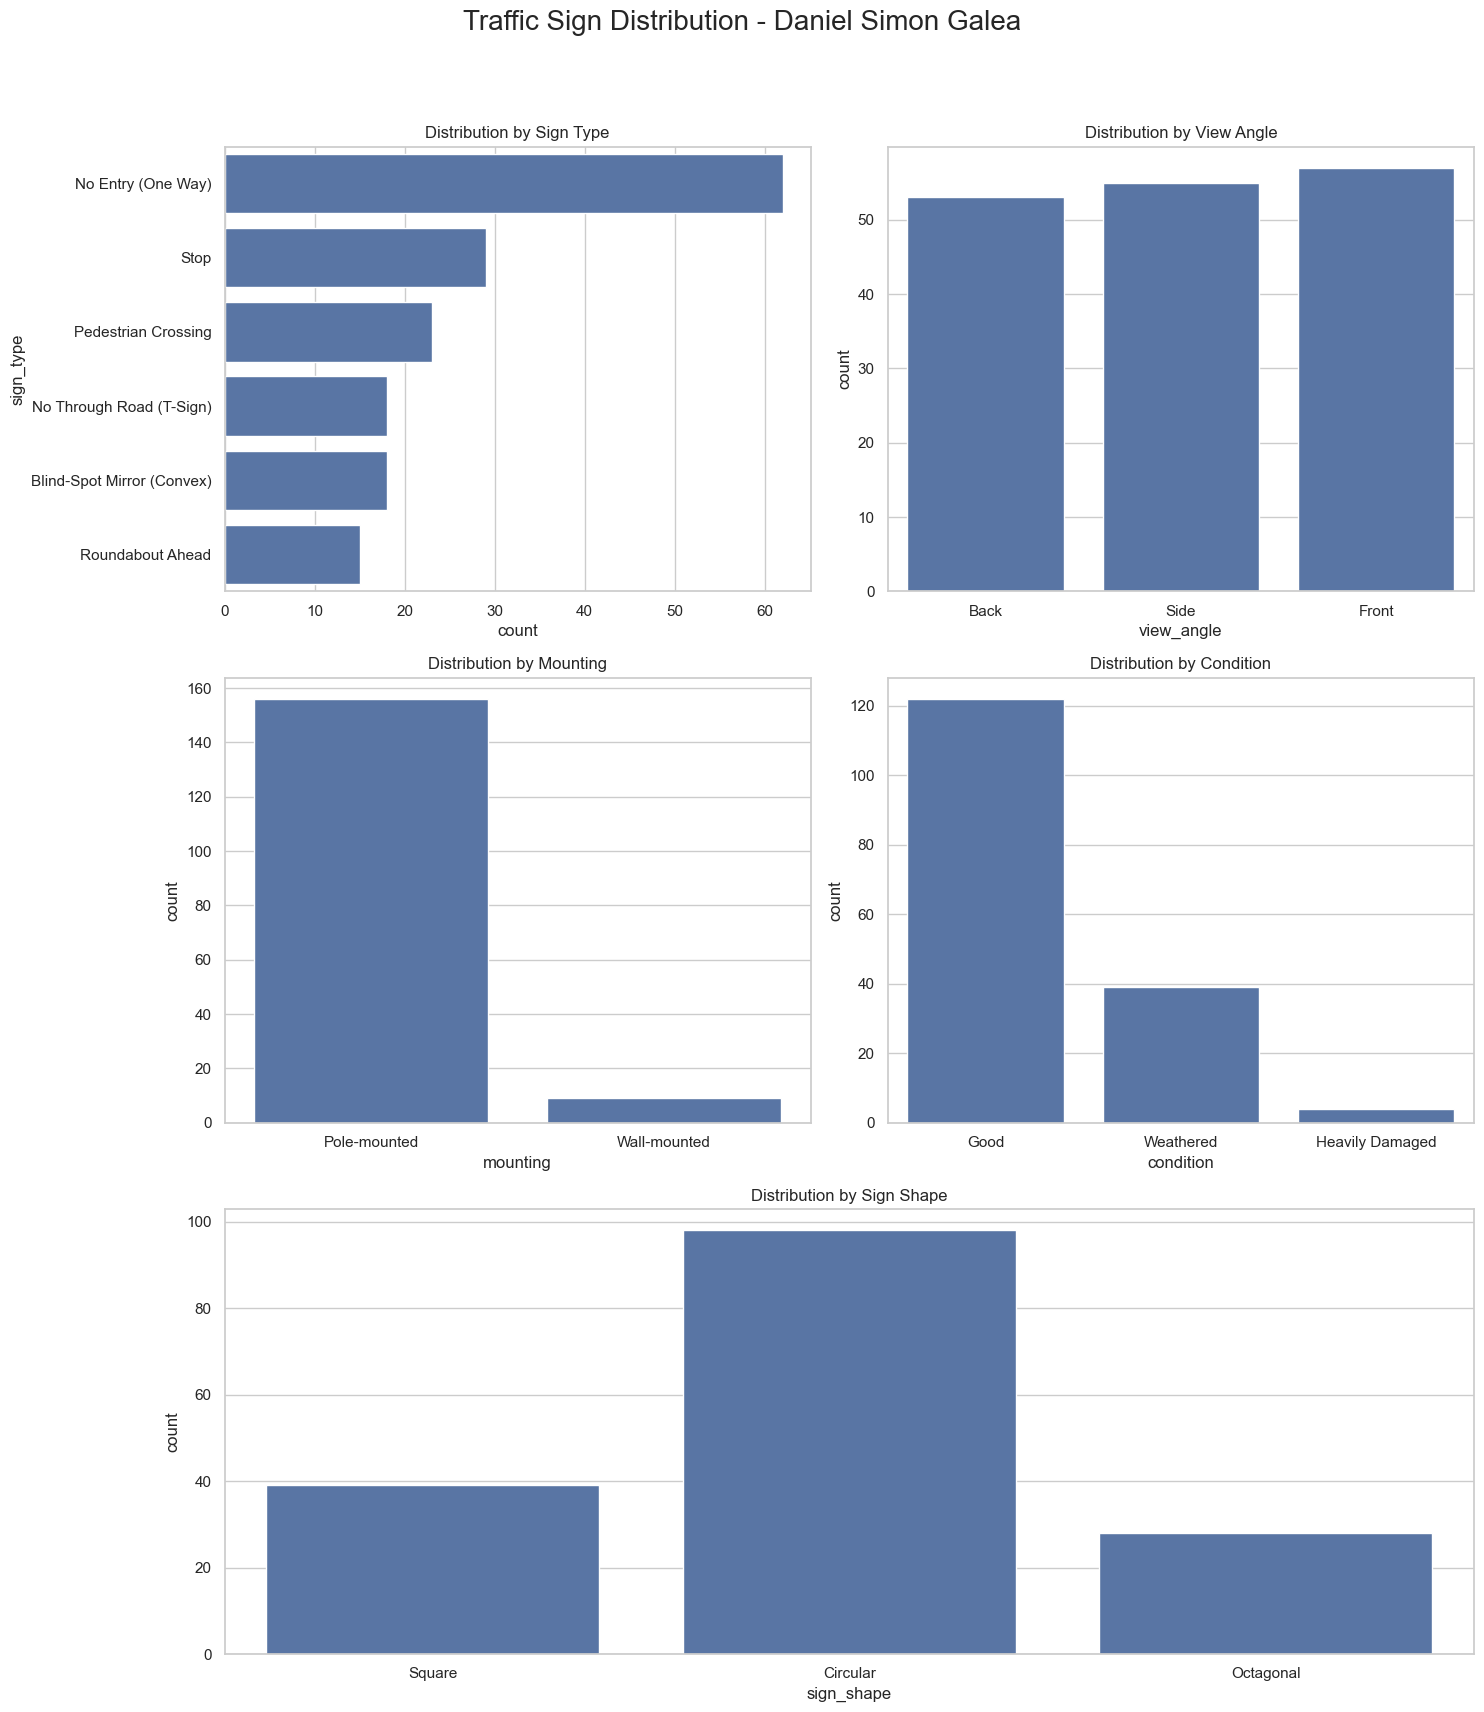

In [9]:
plot_distribution(df_daniel, "Daniel Simon Galea")

## Individual Analysis - Liam Azzopardi

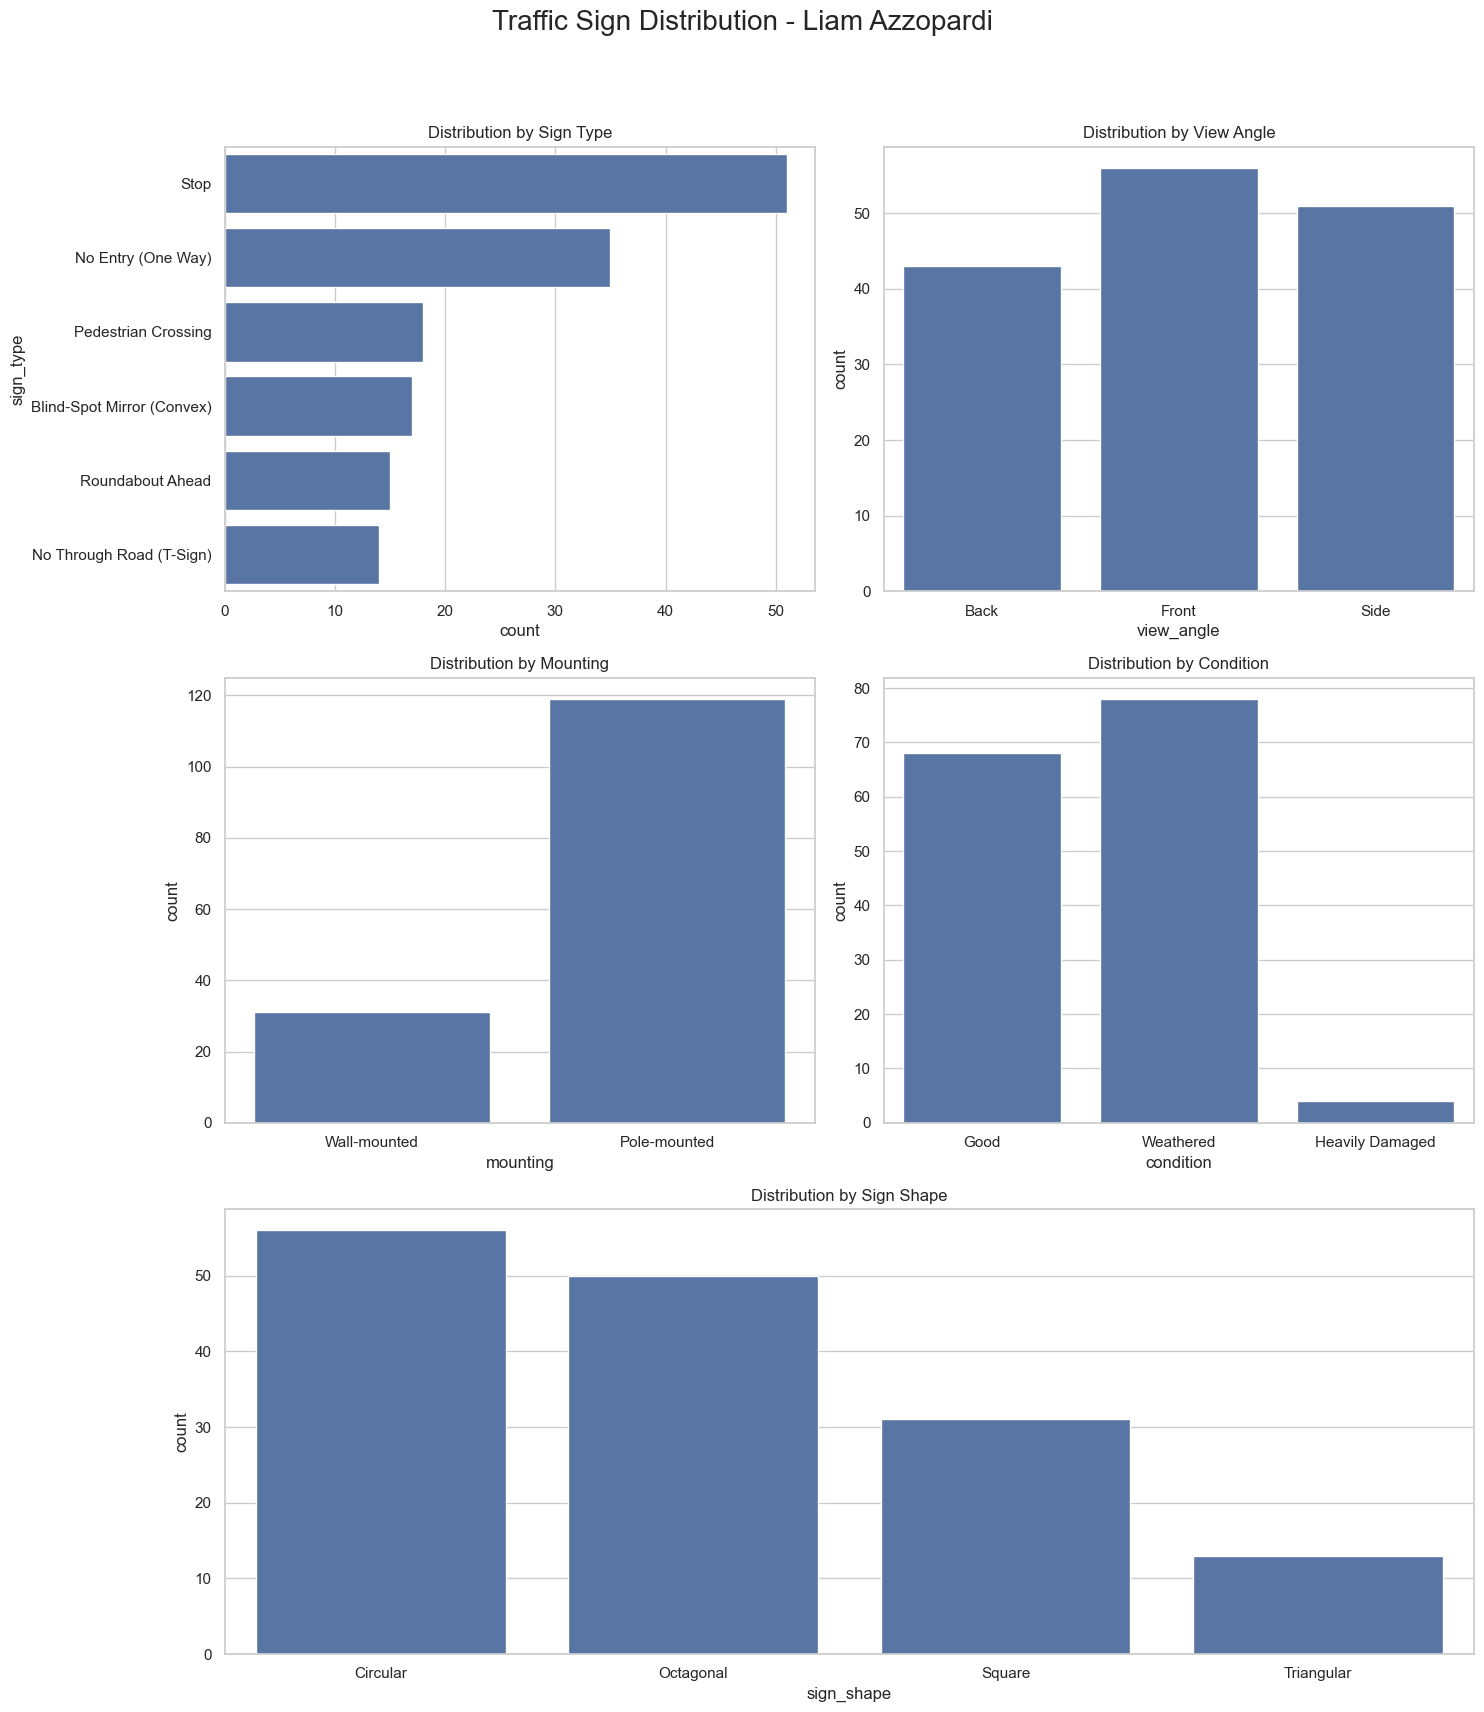

In [10]:
plot_distribution(df_liam_azz, "Liam Azzopardi")

## Individual Analysis - Liam Jake Vella

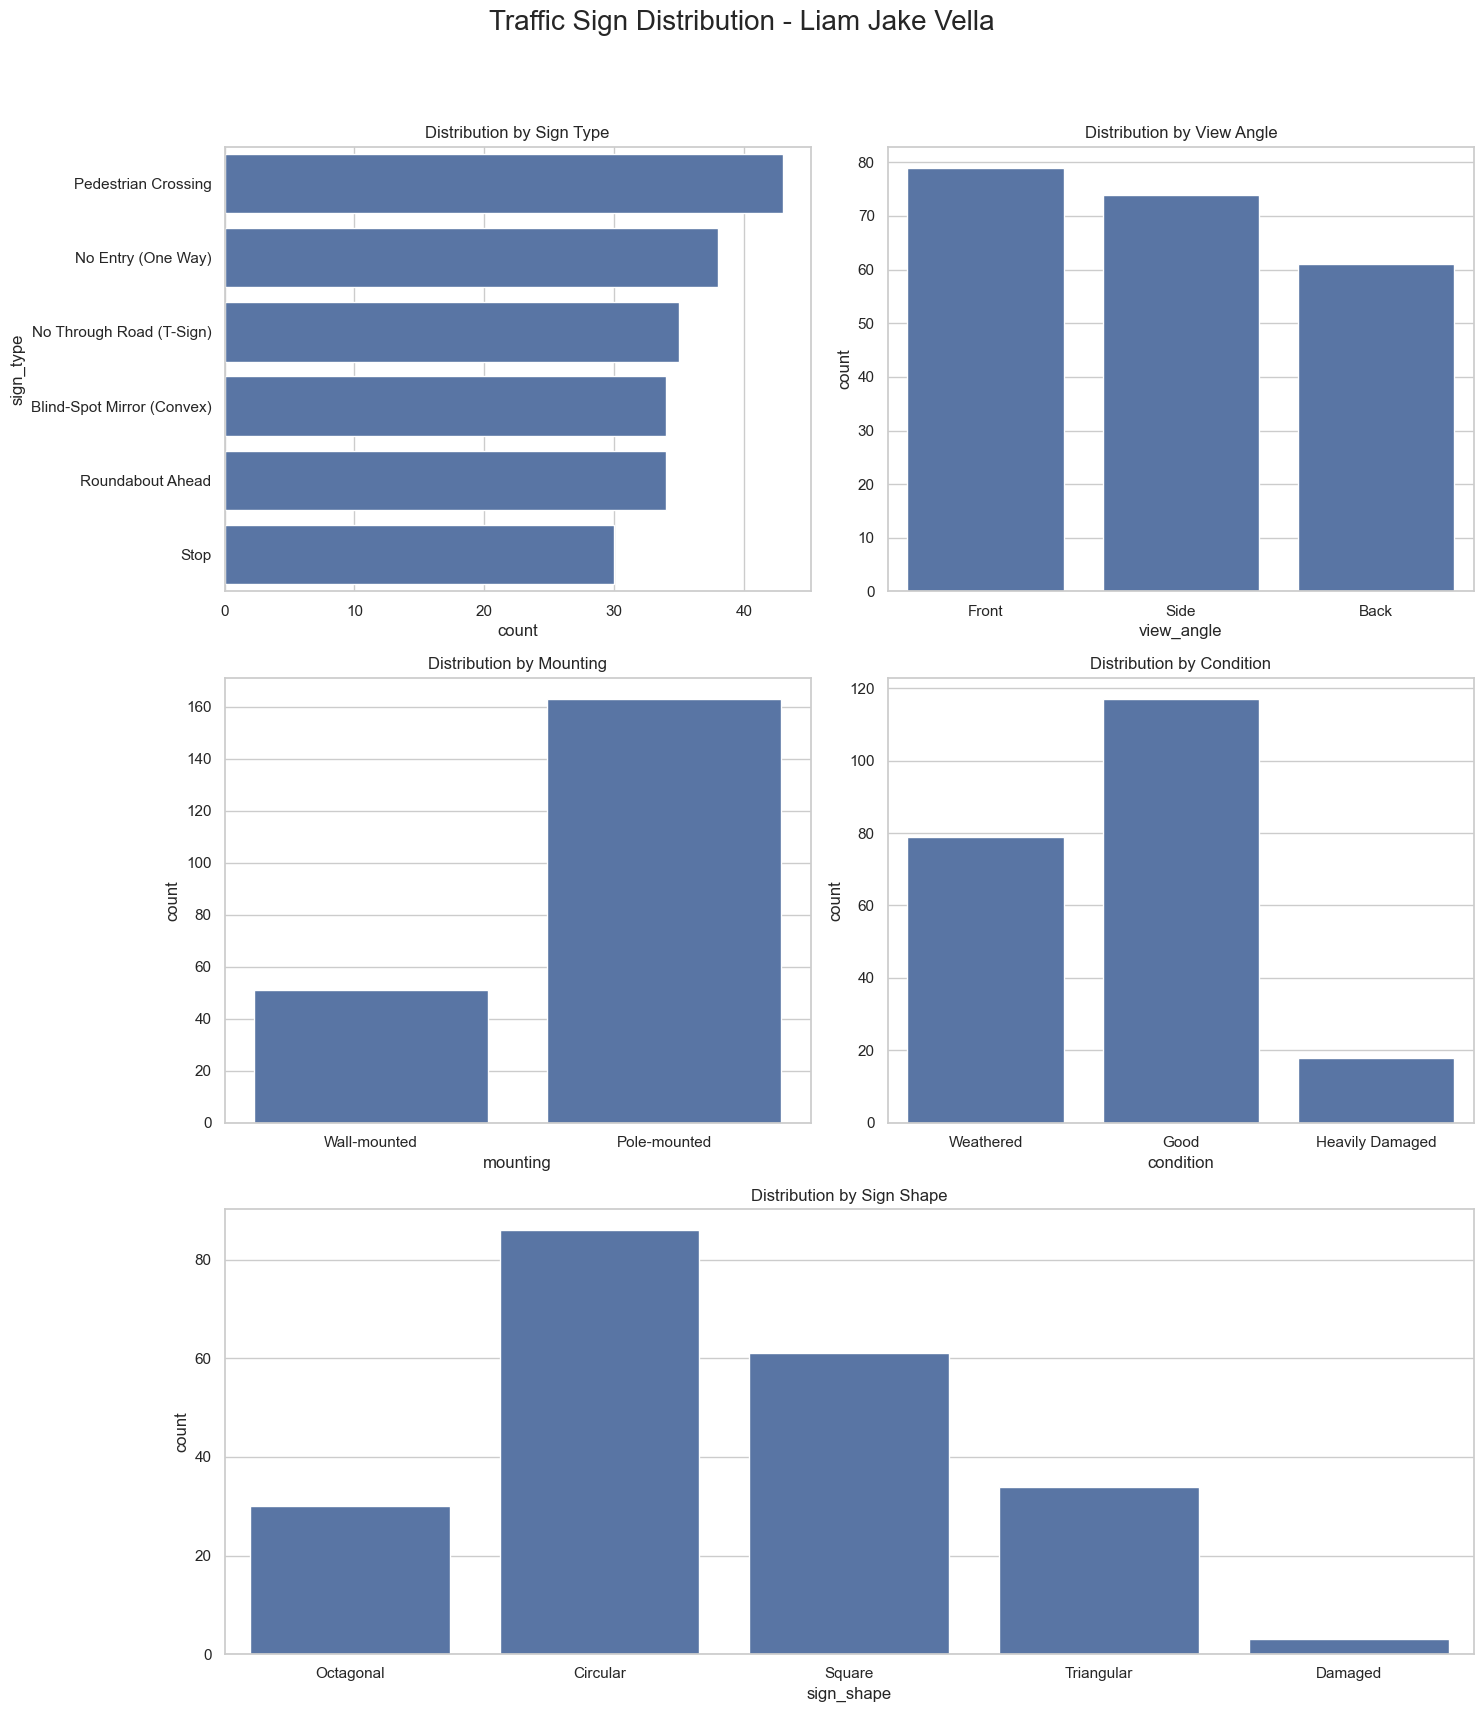

In [11]:
plot_distribution(df_liam_jake, "Liam Jake Vella")

## Individual Analysis - Matthew Privitera

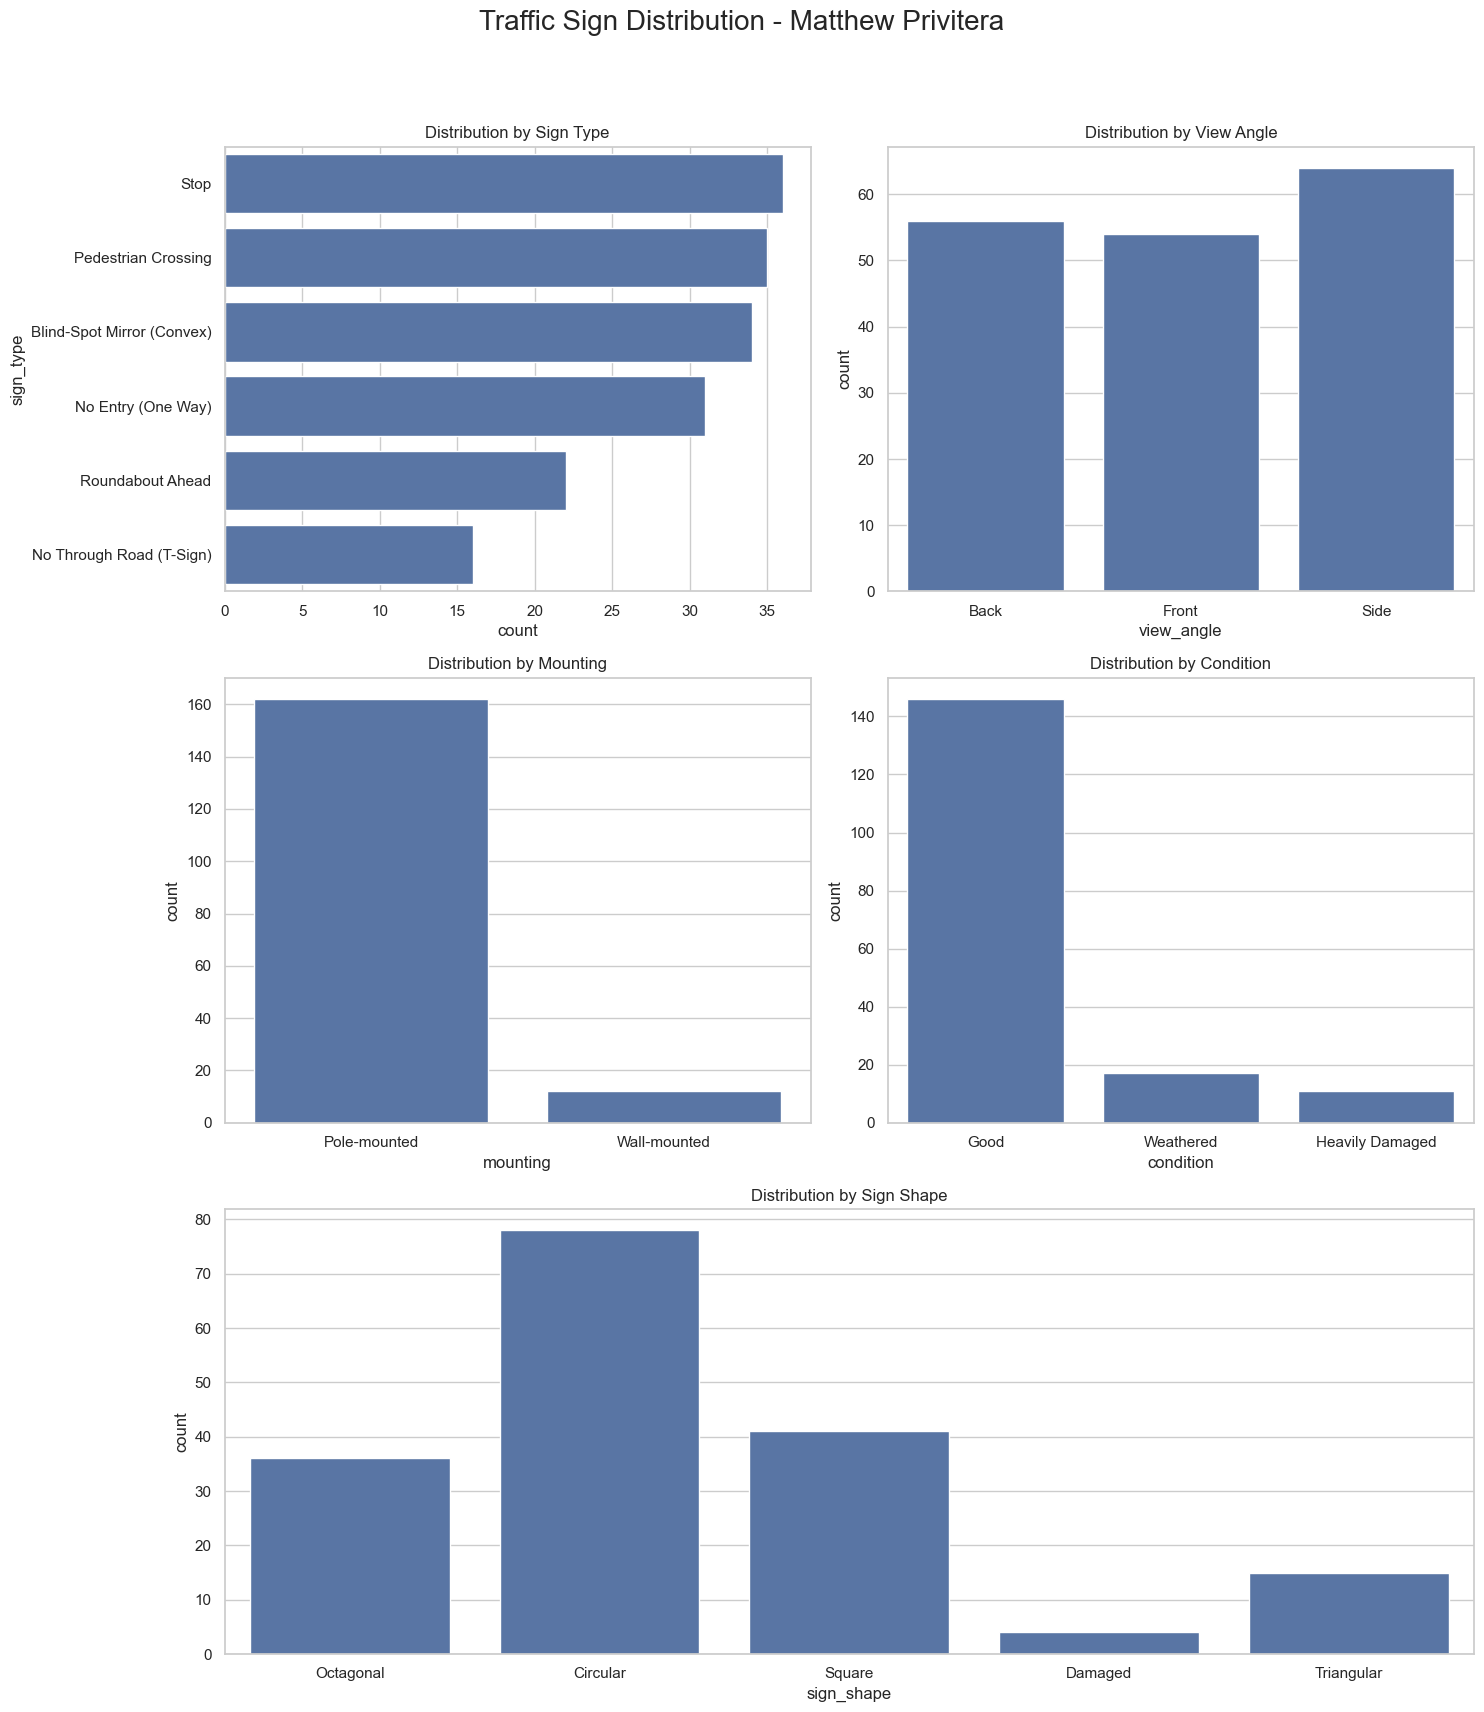

In [12]:
plot_distribution(df_matthew, "Matthew Privitera")

## Geospatial Visualization

Plotting signs with valid GPS coordinates on an interactive map.

In [13]:
gps_df = df[df['latitude'].notna() & df['longitude'].notna()]

if len(gps_df) > 0:
    # Create map centered on mean coordinates
    center_lat = gps_df['latitude'].mean()
    center_lon = gps_df['longitude'].mean()
    
    # Create folium map
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=12,
        tiles='OpenStreetMap'
    )
    
    # Add markers for each image
    marker_cluster = plugins.MarkerCluster().add_to(m)
    
    for _, row in gps_df.iterrows():
        # Create popup text
        popup_text = f"""
        <b>File:</b> {row['image_filename']}<br>
        <b>Sign Type:</b> {', '.join(set(row['sign_type']))}<br>
        <b>Lat:</b> {row['latitude']:.6f}<br>
        <b>Lon:</b> {row['longitude']:.6f}
        """
        
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=folium.Popup(popup_text, max_width=300),
            tooltip=row['image_filename']
        ).add_to(marker_cluster)
    
    # Add heatmap layer
    heat_data = [[row['latitude'], row['longitude']] for _, row in gps_df.iterrows()]
    plugins.HeatMap(heat_data, radius=15, blur=25, max_zoom=13).add_to(m)
    
    # Save map
    map_path = os.path.join(BASE_DIR, 'gps_map.html')
    m.save(map_path)
    
    print(f"\nInteractive GPS map saved to: {map_path}")
    print("\nOpen this file in a web browser to view the interactive map!")
    
    # Display the map in notebook
    display(m)
    
else:
    print("\nCannot create GPS map - no GPS data available in images")


Interactive GPS map saved to: C:\Users\liamj\Desktop\Advanced-CV-ARI3129\gps_map.html

Open this file in a web browser to view the interactive map!
